# Classification Fine Tuning a Pre-Trained Model

Here I am classification finetuning a pretrained model on for sentiment detection from tweets.

Dataset: https://huggingface.co/datasets/cardiffnlp/tweet_eval
The dataset consists of tweets with labels for sentiments where the labels are one of the following:
- 0: negative
- 1: neutral
- 2: positive

PreTrained Model: https://huggingface.co/HuggingFaceTB/SmolLM2-360M
This is a pretrained transformer model. It is designed to be fast and efficient.

# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForMaskedLM, AutoTokenizer

# Defining various necessary functions

# Downloading the dataset

In [2]:
splits = {
    "train": "sentiment/train-00000-of-00001.parquet",
    "test": "sentiment/test-00000-of-00001.parquet",
    "validation": "sentiment/validation-00000-of-00001.parquet",
}
dataframes = {}

# Load each split into the dictionary
for split_name, split_path in splits.items():
    dataframes[split_name] = pd.read_parquet(
        "hf://datasets/cardiffnlp/tweet_eval/" + split_path
    )
    print(f"\n{split_name.upper()} dataset:")
    print(dataframes[split_name]["label"].value_counts())
    print(f"Total samples in {split_name}: {len(dataframes[split_name])}")

# Access individual dataframes
train_df = dataframes["train"]
test_df = dataframes["test"]
validation_df = dataframes["validation"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



TRAIN dataset:
label
1    20673
2    17849
0     7093
Name: count, dtype: int64
Total samples in train: 45615

TEST dataset:
label
1    5937
0    3972
2    2375
Name: count, dtype: int64
Total samples in test: 12284

VALIDATION dataset:
label
1    869
2    819
0    312
Name: count, dtype: int64
Total samples in validation: 2000


As we can see sentiment 0 (negative) has the lowest number of training samples. Thus we balance the datset with this in mind  

In [3]:
def create_balanced_dataset(df):
    # Get counts for each label
    label_counts = df["label"].value_counts()

    # Find the minimum count (which is for label 0 - negative)
    min_count = label_counts.min()

    balanced_samples = []

    # For each label, sample exactly min_count examples
    for label in label_counts.index:
        label_samples = df[df["label"] == label].sample(min_count, random_state=123)
        balanced_samples.append(label_samples)

    # Combine all balanced samples
    balanced_df = pd.concat(balanced_samples)

    # Shuffle the final dataframe
    balanced_df = balanced_df.sample(frac=1, random_state=123).reset_index(drop=True)

    return balanced_df


# Example usage:
balanced_train_df = create_balanced_dataset(train_df)
print(balanced_train_df["label"].value_counts())
print(f"Total samples in balanced training set: {len(balanced_train_df)}")

label
2    7093
1    7093
0    7093
Name: count, dtype: int64
Total samples in balanced training set: 21279


# Creating Data Loaders

## Padding all messages the longest message in the dataset

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.data = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, index):
        text = self.data.iloc[index]["text"]
        label = self.data.iloc[index]["label"]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

    def __len__(self):
        return len(self.data)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
train_dataset = SentimentDataset(balanced_train_df, tokenizer=tokenizer)

validation_dataset = SentimentDataset(validation_df, tokenizer=tokenizer)

test_dataset = SentimentDataset(test_df, tokenizer=tokenizer)

In [7]:
print(train_dataset.max_length)

128


In [8]:
num_workers = 0
batch_size = 32

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

In [9]:
print(f"{len(train_loader)} training batches")
print(f"{len(validation_loader)} validation batches")
print(f"{len(test_loader)} test batches")

664 training batches
63 validation batches
384 test batches


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = AutoModelForMaskedLM.from_pretrained("FacebookAI/roberta-base").to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [11]:
print(model)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [12]:
print(model.config)
config = model.config
embedding_size = config.hidden_size
context_length = config.max_position_embeddings
vocab_size = config.vocab_size

RobertaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [13]:
class RobertaForSentimentClassification(nn.Module):
    def __init__(self, base_model, num_labels=3):
        super().__init__()
        self.roberta = base_model.roberta

        # Replace the LM head with a classification head
        self.classifier = nn.Sequential(
            nn.Linear(768, 768), nn.ReLU(), nn.Dropout(0.1), nn.Linear(768, num_labels)
        )

        # Initialize the classification head
        self._init_weights(self.classifier)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state[
            :, 0, :
        ]  # Use [CLS] token representation
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return type("ModelOutput", (), {"loss": loss, "logits": logits})

In [14]:
model = RobertaForSentimentClassification(model, num_labels=3).to(device)
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier (modified LM head)
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last transformer layer
for param in model.roberta.encoder.layer[-1].parameters():
    param.requires_grad = True
# Print the updated model
print(model)

RobertaForSentimentClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

# Calculating Classification Loss and Accuracy

In [15]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    num_examples = 0
    correct_predictions = 0

    for i, batch in enumerate(data_loader):
        if num_batches is not None and i >= num_batches:
            break

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

        num_examples += predicted_labels.shape[0]
        correct_predictions += (predicted_labels == labels).sum().item()

    return correct_predictions / num_examples

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(
    device
)  # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(
    123
)  # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(validation_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 37.50%
Validation accuracy: 38.75%
Test accuracy: 21.56%


In [17]:
def calc_loss_batch(batch, model, device):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    return outputs.loss

In [18]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss = 0.0

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches if num_batches exceeds the total available
        num_batches = min(num_batches, len(data_loader))

    for i, batch in enumerate(data_loader):
        if i < num_batches:
            # Using the new calc_loss_batch that expects a dictionary batch
            loss = calc_loss_batch(batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [19]:
with torch.no_grad():  # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(validation_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 1.095
Validation loss: 1.080
Test loss: 1.107


# Finetuning the model

In [20]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [21]:
def train_classifier_simple(
    model,
    train_loader,
    validation_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    best_val_loss = float('inf')

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            # Forward pass
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )

            loss = outputs.loss
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients

            examples_seen += input_ids.shape[0]
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, validation_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), "roberta_classifier.pth")
                    print(f"Saved best model to roberta_classifier.pth with validation loss: {best_val_loss:.3f}")


        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            validation_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [22]:
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model,
    train_loader,
    validation_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
)

Ep 1 (Step 000000): Train loss 1.101, Val loss 1.081
Saved best model to roberta_classifier.pth with validation loss: 1.081
Ep 1 (Step 000050): Train loss 1.082, Val loss 1.061
Saved best model to roberta_classifier.pth with validation loss: 1.061
Ep 1 (Step 000100): Train loss 0.798, Val loss 0.930
Saved best model to roberta_classifier.pth with validation loss: 0.930
Ep 1 (Step 000150): Train loss 0.691, Val loss 0.861
Saved best model to roberta_classifier.pth with validation loss: 0.861
Ep 1 (Step 000200): Train loss 0.674, Val loss 0.843
Saved best model to roberta_classifier.pth with validation loss: 0.843
Ep 1 (Step 000250): Train loss 0.628, Val loss 0.738
Saved best model to roberta_classifier.pth with validation loss: 0.738
Ep 1 (Step 000300): Train loss 0.622, Val loss 0.782
Ep 1 (Step 000350): Train loss 0.735, Val loss 0.812
Ep 1 (Step 000400): Train loss 0.661, Val loss 0.820
Ep 1 (Step 000450): Train loss 0.669, Val loss 0.803
Ep 1 (Step 000500): Train loss 0.639, Val lo

In [33]:
model.load_state_dict(torch.load("roberta_classifier.pth"))
model.eval()

RobertaForSentimentClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [34]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

plotting losses

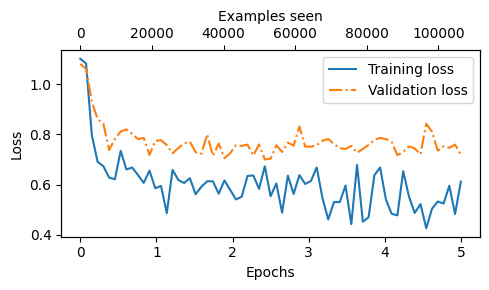

In [35]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Plotting accuracy

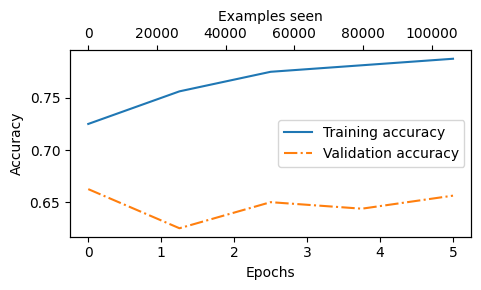

In [36]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [37]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(validation_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 74.87%
Validation accuracy: 70.80%
Test accuracy: 67.10%


In [38]:
def classify_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()

    # Tokenize and prepare inputs
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Model inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    predicted_label = torch.argmax(logits, dim=1).item()

    # Map the predicted label to sentiment
    sentiments = {0: "negative", 1: "neutral", 2: "positive"}
    return sentiments[int(predicted_label)]

In [39]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(
    classify_sentiment(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

positive


In [32]:
from google.colab import files

files.download("roberta_classifier.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>